
## Overview

This notebook will show you how to create and query a table or DataFrame that you uploaded to DBFS. [DBFS](https://docs.databricks.com/user-guide/dbfs-databricks-file-system.html) is a Databricks File System that allows you to store data for querying inside of Databricks. This notebook assumes that you have a file already inside of DBFS that you would like to read from.

This notebook is written in **Python** so the default cell type is Python. However, you can use different languages by using the `%LANGUAGE` syntax. Python, Scala, SQL, and R are all supported.

In [0]:
%pip install sparkxgb
%pip install torch

Python interpreter will be restarted.
  Created wheel for sparkxgb: filename=sparkxgb-0.1-py3-none-any.whl size=5654 sha256=e2f9034d6f2eb9f8e93f58cd974de33654f36e1e5f8b8567b758a1325be82cd4
  Stored in directory: /root/.cache/pip/wheels/a0/8b/56/b552f1fcc0c2ace33c4099565fec6c1d5804add53bfa7dec14
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767605 sha256=26c2a26fa0fe2d78d6e273f79e305841602ee7f7dabf04d4d4368bdc46d47746
  Stored in directory: /root/.cache/pip/wheels/23/bf/e9/9f3500437422e2ab82246f25a51ee480a44d4efc6c27e50d33
Successfully built sparkxgb pyspark
Python interpreter will be restarted.
Python interpreter will be restarted.
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-e20836ac-fe25-402e-b1e9-00461cc71512
    Can't uninstall 'typing-extensi

In [0]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import DataFrame
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
import seaborn as sns
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from sparkxgb import XGBoostClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.mllib.evaluation import MulticlassMetrics

In [0]:
# File location and type
file_location = "/FileStore/tables/diabetes_012_health_indicators_BRFSS2015.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df)

In [0]:
num_rows = df.count()

# Get the number of columns
num_cols = len(df.columns)

# Display the shape of the DataFrame
print("Shape of DataFrame: {} rows x {} columns".format(num_rows, num_cols))

Shape of DataFrame: 253680 rows x 22 columns


In [0]:
descriptive_stats = df.describe()
display(descriptive_stats)

summary,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680,253680,253680,253680,253680,253680,253680,253680,253680,253680,253680,253680,253680,253680,253680,253680,253680,253680,253680,253680,253680,253680
mean,0.29692131819615264,0.4290011037527594,0.4241209397666351,0.9626695048880479,28.382363607694735,0.44316855881425415,0.04057079785556607,0.09418558814254178,0.7565436770734784,0.6342557552822453,0.811419899085462,0.05619678334910123,0.9510525070955534,0.08417691579943236,2.5113923052664773,3.1847721538946705,4.2420805739514345,0.16822374645222327,0.4403421633554084,8.032119205298013,5.050433617155472,6.053874960580258
stddev,0.6981597284091021,0.4949344626899021,0.49420980465688547,0.1895707543627256,6.608694201406024,0.4967606667785641,0.19729409940016224,0.2920873147507561,0.4291690433970457,0.4816391871704347,0.39117547168449035,0.23030178889522906,0.21575870631073912,0.27765350085762475,1.0684773622803927,7.412846696196172,8.717951307175133,0.3740655947328032,0.49642916311850555,3.054220434168482,0.9857741757276497,2.0711475662715153
min,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
max,2.0,1.0,1.0,1.0,98.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,30.0,30.0,1.0,1.0,13.0,6.0,8.0


In [0]:
unique_values = df.select("Diabetes_012").distinct().collect()

# Extract the unique values from the result
unique_values_list = [row["Diabetes_012"] for row in unique_values]

# Print the unique values
print("Unique values of column 'Diabetes_012':", unique_values_list)

Unique values of column 'Diabetes_012': [0.0, 1.0, 2.0]


In [0]:
# Assuming 'df' is your DataFrame

# Group by 'Diabetes_012' column and count the occurrences of each value
class_counts = df.groupBy('Diabetes_012').count().orderBy('Diabetes_012').collect()

# Extract values for plotting
labels = [row['Diabetes_012'] for row in class_counts]
counts = [row['count'] for row in class_counts]

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color='skyblue')
plt.title('Count Of Diabetes labels')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Annotate each bar with its count and percentage
for i, count in enumerate(counts):
    percentage = (count / sum(counts)) * 100
    plt.text(i, count + 0.1, f'{count} ({percentage:.2f}%)', ha='center', va='bottom')

# Show the plot
plt.show()


In [0]:
new_df = df.toPandas()
new_df.head()
new_df.shape

Out[7]: (253680, 22)

In [0]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

Out[9]: <AxesSubplot:xlabel='HighBP', ylabel='BMI'>

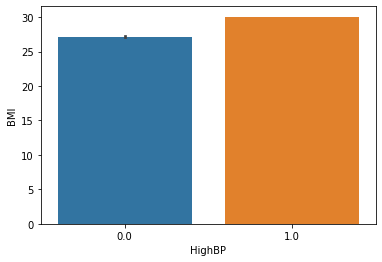

In [0]:
sb.barplot(data=new_df, x="HighBP", y="BMI")

In [0]:
sb.histplot(data=new_df, x="BMI", kde=True)

Out[11]: <AxesSubplot:xlabel='CholCheck', ylabel='BMI'>

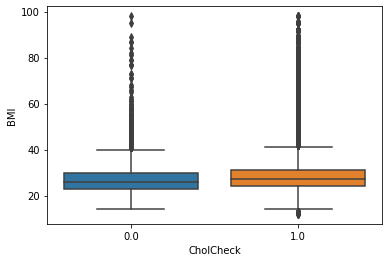

In [0]:
sb.boxplot(data=new_df, x="CholCheck", y="BMI")

Out[12]: <AxesSubplot:xlabel='Age', ylabel='BMI'>

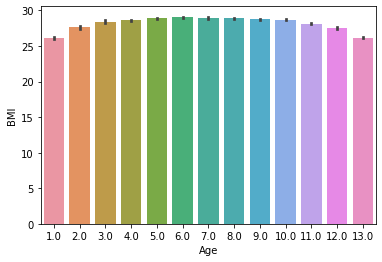

In [0]:
sb.barplot(data=new_df, x="Age", y="BMI")

In [0]:
pd.crosstab(new_df["HighChol"], new_df["HeartDiseaseorAttack"])

HeartDiseaseorAttack,0.0,1.0
HighChol,,
0.0,138949,7140
1.0,90838,16753


In [0]:
pd.crosstab([new_df["Fruits"], new_df["Veggies"]], new_df["HeartDiseaseorAttack"])

HeartDiseaseorAttack 
 0.0 
 1.0 
 
 
 Fruits 
 Veggies 
 
 
 
 
 
 
 0.0 
 0.0 
 26154 
 3499 
 
 
 1.0 
 57183 
 5946 
 
 
 1.0 
 0.0 
 16044 
 2142 
 
 
 1.0 
 130406 
 12306

Out[15]: <AxesSubplot:xlabel='Stroke', ylabel='BMI'>

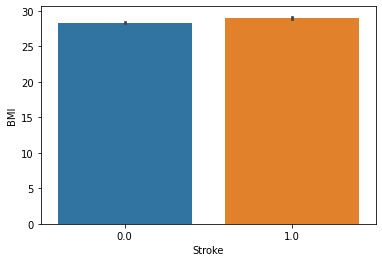

In [0]:
sb.barplot(data=new_df, x="Stroke", y="BMI")

In [0]:
pd.crosstab(new_df["Smoker"], new_df["Stroke"])

Stroke,0.0,1.0
Smoker,,
0.0,137047,4210
1.0,106341,6082


In [0]:
pd.crosstab(new_df["HvyAlcoholConsump"], new_df["HeartDiseaseorAttack"])

HeartDiseaseorAttack,0.0,1.0
HvyAlcoholConsump,,
0.0,216379,23045
1.0,13408,848


Out[18]: <AxesSubplot:xlabel='HvyAlcoholConsump', ylabel='BMI'>

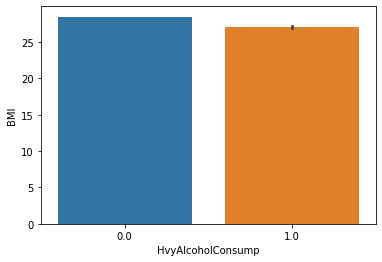

In [0]:
sb.barplot(data=new_df, x="HvyAlcoholConsump", y="BMI")

In [0]:
corr = df.toPandas().corr()
# Plot the heatmap
plt.figure(figsize=(20, 10))
sb.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

RDDs can also be used for performing these operations, but it would take much more time for simple preprocessing activities

In [0]:
df_cleaned = df.dropDuplicates()

# Show all duplicate rows (if any)
print("All Duplicate Rows after dropping duplicates:")
df_cleaned.registerTempTable("df_cleaned_table")
duplicate_rows = spark.sql("""
    SELECT *
    FROM df_cleaned_table
    GROUP BY {}
    HAVING COUNT(*) > 1
""".format(", ".join(df_cleaned.columns)))
display(duplicate_rows)


All Duplicate Rows after dropping duplicates:


/databricks/spark/python/pyspark/sql/dataframe.py:331: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income


Spark SQL used

In [0]:
num_rows = df_cleaned.count()

# Get the number of columns
num_cols = len(df_cleaned.columns)

# Show the shape of the DataFrame
print("Shape of DataFrame after cleaning: {} rows x {} columns".format(num_rows, num_cols))

Shape of DataFrame after cleaning: 229781 rows x 22 columns


In [0]:
quantiles = df_cleaned.stat.approxQuantile("BMI", [0.25, 0.75], 0.05)
Q1 = quantiles[0]
Q3 = quantiles[1]

# Calculate IQR and bounds
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
df_cleaned = df_cleaned.filter((col("BMI") >= lower_bound) & (col("BMI") <= upper_bound))

# Show the cleaned DataFrame
display(df_cleaned)

In [0]:
df_cleaned = df_cleaned.drop('AnyHealthcare','Sex','Fruits')

In [0]:
def smote(df_cleaned: DataFrame, minority_labels: list, k: int = 20, over_sampling_ratio: float = 1.0, seed: int = 42) -> DataFrame:
    
    label_column = 'Diabetes_012'

    # Separate majority and minority classes
    majority_df = df_cleaned.filter(col(label_column) == 0.0)
    minority_dfs = [df_cleaned.filter(col(label_column) == label) for label in minority_labels]
    
    # Compute the number of synthetic samples to generate
    majority_count = majority_df.count()
    synthetic_count = int(majority_count * over_sampling_ratio)
    
    synthetic_dfs = []
    
    for minority_df in minority_dfs:
        # Compute SMOTE for each minority class
        synthetic_df = compute_smote(minority_df, k, synthetic_count, seed)
        synthetic_dfs.append(synthetic_df)

    # Union all synthetic minority class DataFrames with majority DataFrame
    oversampled_df = majority_df
    for synthetic_df in synthetic_dfs:
        oversampled_df = oversampled_df.union(synthetic_df)
    
    
    return oversampled_df


def compute_smote(minority_df: DataFrame, k: int, synthetic_count: int, seed: int) -> DataFrame:
    
    # Collect minority samples into a list
    minority_samples = minority_df.collect()
    
    # Initialize synthetic samples list
    synthetic_samples = []

    # Generate synthetic samples using SMOTE
    np.random.seed(seed)
    num_minority_samples = len(minority_samples)
    
    for i in range(synthetic_count):
        # Randomly choose a minority sample
        sample = minority_samples[np.random.randint(0, num_minority_samples)]
        
        # Find k nearest neighbors for the selected sample
        nn_indices = np.random.choice(num_minority_samples, k, replace=True)
        
        # Randomly select one of the nearest neighbors
        nn_sample = minority_samples[np.random.choice(nn_indices)]
        
        # Create a synthetic sample based on the nearest neighbor
        synthetic_sample = [sample[idx] + np.random.rand() * (nn_sample[idx] - sample[idx]) for idx in range(len(sample))]
        synthetic_samples.append(synthetic_sample)
    
    # Create DataFrame with synthetic samples
    schema = minority_df.schema
    synthetic_data = spark.createDataFrame(synthetic_samples, schema=schema)
    return synthetic_data

# Example usage
label_column = "Diabetes_012"
minority_labels = [1.0, 2.0]
oversampled_df = smote(df_cleaned, minority_labels, k=10, over_sampling_ratio=1.0, seed=42)

In [0]:
class_counts = oversampled_df.groupBy(label_column).count()

# Display the count of each class
class_counts.show()

# Plot the count of each class
class_counts.toPandas().plot(kind='bar', x=label_column, y='count', title='Count (Target)')

In [0]:
# Convert PySpark DataFrames to Pandas DataFrames
df_original_pd = df_cleaned.toPandas()
oversampled_pd = oversampled_df.toPandas()

# Assuming feature_columns contains the relevant feature names
feature_columns = ['Diabetes_012', 'Education']  # Replace with your feature names

# Plot histograms for each feature
for feature in feature_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_original_pd[feature], color='blue', alpha=0.5, label='Original')
    sns.histplot(oversampled_pd[feature], color='orange', alpha=0.5, label='Oversampled')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [0]:
# Assuming df_original and smote_df are the original and oversampled PySpark DataFrames

# Summary statistics for the original data
original_summary = df_cleaned.describe()

# Summary statistics for the oversampled data
oversampled_summary = oversampled_df.describe()

# Display the summary statistics
print("Summary statistics for original data:")
display(original_summary)

print("Summary statistics for oversampled data:")
display(oversampled_summary)


Summary statistics for original data:


summary,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Veggies,HvyAlcoholConsump,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Education,Income
count,219937,219937,219937,219937,219937,219937,219937,219937,219937,219937,219937,219937,219937,219937,219937,219937,219937,219937,219937
mean,0.30826100201421314,0.4457594674838704,0.44022606473672005,0.958860946543783,27.798246770666147,0.46691552580966367,0.04444454548347936,0.10234749041771053,0.7412349900198694,0.7965781110045149,0.06206322719687911,0.0903167725303155,2.571436365868408,3.3928943288305287,4.4967058748641655,0.1737588491249767,8.123157995244092,4.988678576137712,5.9239918703992505
stddev,0.7083612144318086,0.4970503877373994,0.49641534737774284,0.1986122128470222,5.055623512043926,0.49890535102866695,0.20608110286575318,0.30310542612532687,0.4379572486987893,0.4025446072663909,0.24127090106554344,0.286635703797807,1.0569969920544982,7.583081472244158,8.882261975519125,0.378902842746788,3.1059315798275775,0.9914560474845354,2.077879926464328
min,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
max,2.0,1.0,1.0,1.0,41.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,30.0,30.0,1.0,13.0,6.0,8.0


Summary statistics for oversampled data:


summary,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Veggies,HvyAlcoholConsump,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Education,Income
count,551607,551607,551607,551607,551607,551607,551607,551607,551607,551607,551607,551607,551607,551607,551607,551607,551607,551607,551607
mean,1.0,0.5868048308553839,0.5631178354005211,0.9774111652987246,29.058035207993633,0.490926957711528,0.06301948786528816,0.15096922758152506,0.6975623442639164,0.778587754005916,0.046166638320117935,0.1057537679536172,2.883225847214398,3.952132732417209,5.870002313585773,0.2504524036564994,8.849037052547216,4.857950242004374,5.558021858012516
stddev,0.8164973210358928,0.4420872247739078,0.44190053438957955,0.14095315779726575,4.5863475821257556,0.44088641292683406,0.2082744161893265,0.30790147415830366,0.40205650198690285,0.3641627858143935,0.19119465034479713,0.26830283547699135,0.9588972623333398,7.239423523450425,8.687846426192568,0.3756157993386641,2.559985228844453,0.9151774922485839,1.9117782770965832
min,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
max,2.0,1.0,1.0,1.0,41.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,30.0,30.0,1.0,13.0,6.0,8.0


In [0]:
# Extract Diabetes_012 column from original and SMOTE datasets
original_diabetes = df_cleaned.select("Education").rdd.flatMap(lambda x: x).collect()
smote_diabetes = oversampled_df.select("Education").rdd.flatMap(lambda x: x).collect()

# Plot PDFs
plt.figure(figsize=(10, 6))
sns.histplot(original_diabetes, kde=True, color='blue', label='Original', stat='density')
sns.histplot(smote_diabetes, kde=True, color='orange', label='SMOTE', stat='density')
plt.title('PDF of Diabetes_012')
plt.xlabel('Diabetes_012')
plt.ylabel('Density')
plt.legend()
plt.show()

In [0]:
# Define feature columns
feature_columns = oversampled_df.columns[1:]  # Exclude the first column
label_column = "Diabetes_012"

# VectorAssembler to create feature vector
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
output = vector_assembler.transform(oversampled_df)
output.select("features","Diabetes_012").show(5)

+--------------------+------------+
|            features|Diabetes_012|
+--------------------+------------+
|(18,[1,2,3,7,8,11...|         0.0|
|(18,[1,2,3,8,11,1...|         0.0|
|(18,[2,3,4,8,11,1...|         0.0|
|(18,[1,3,7,11,15,...|         0.0|
|[1.0,1.0,1.0,24.0...|         0.0|
+--------------------+------------+
only showing top 5 rows



In [0]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
# Fit StandardScaler to data and transform
scaler_model = scaler.fit(output)
scaled_output = scaler_model.transform(output)
# Show the features and label columns
scaled_output.select("scaled_features", "Diabetes_012").show(5)

+--------------------+------------+
|     scaled_features|Diabetes_012|
+--------------------+------------+
|(18,[1,2,3,7,8,11...|         0.0|
|(18,[1,2,3,8,11,1...|         0.0|
|(18,[2,3,4,8,11,1...|         0.0|
|(18,[1,3,7,11,15,...|         0.0|
|[2.26199705388777...|         0.0|
+--------------------+------------+
only showing top 5 rows



In [0]:
train, test = scaled_output.randomSplit([0.8, 0.2], seed=17)
test.groupBy('Diabetes_012').count().show()

+------------+-----+
|Diabetes_012|count|
+------------+-----+
|         0.0|36965|
|         1.0|36724|
|         2.0|36901|
+------------+-----+



In [0]:
train.groupBy('Diabetes_012').count().show()

+------------+------+
|Diabetes_012| count|
+------------+------+
|         0.0|146904|
|         1.0|147145|
|         2.0|146968|
+------------+------+



In [0]:
train.show()

+------------+------+--------+---------+----+------+------+--------------------+------------+-------+-----------------+-----------+-------+--------+--------+--------+----+---------+------+--------------------+--------------------+
|Diabetes_012|HighBP|HighChol|CholCheck| BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Veggies|HvyAlcoholConsump|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk| Age|Education|Income|            features|     scaled_features|
+------------+------+--------+---------+----+------+------+--------------------+------------+-------+-----------------+-----------+-------+--------+--------+--------+----+---------+------+--------------------+--------------------+
|         0.0|   0.0|     0.0|      0.0|16.0|   1.0|   0.0|                 0.0|         0.0|    1.0|              0.0|        1.0|    3.0|     0.0|     7.0|     0.0| 4.0|      5.0|   2.0|(18,[3,4,8,10,11,...|(18,[3,4,8,10,11,...|
|         0.0|   0.0|     0.0|      0.0|17.0|   0.0|   0.0|                 

In [0]:
train.show()

+------------+------+--------+---------+----+------+------+--------------------+------------+-------+-----------------+-----------+-------+--------+--------+--------+----+---------+------+--------------------+--------------------+
|Diabetes_012|HighBP|HighChol|CholCheck| BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Veggies|HvyAlcoholConsump|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk| Age|Education|Income|            features|     scaled_features|
+------------+------+--------+---------+----+------+------+--------------------+------------+-------+-----------------+-----------+-------+--------+--------+--------+----+---------+------+--------------------+--------------------+
|         0.0|   0.0|     0.0|      0.0|16.0|   1.0|   0.0|                 0.0|         0.0|    1.0|              0.0|        1.0|    3.0|     0.0|     7.0|     0.0| 4.0|      5.0|   2.0|(18,[3,4,8,10,11,...|(18,[3,4,8,10,11,...|
|         0.0|   0.0|     0.0|      0.0|17.0|   0.0|   0.0|                 

In [0]:
train.count()

Out[35]: 441017

In [0]:
test.show()

+------------+------+--------+---------+----+------+------+--------------------+------------+-------+-----------------+-----------+-------+--------+--------+--------+----+---------+------+--------------------+--------------------+
|Diabetes_012|HighBP|HighChol|CholCheck| BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Veggies|HvyAlcoholConsump|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk| Age|Education|Income|            features|     scaled_features|
+------------+------+--------+---------+----+------+------+--------------------+------------+-------+-----------------+-----------+-------+--------+--------+--------+----+---------+------+--------------------+--------------------+
|         0.0|   0.0|     0.0|      0.0|14.0|   1.0|   0.0|                 0.0|         1.0|    1.0|              0.0|        0.0|    3.0|     4.0|     4.0|     0.0|11.0|      6.0|   8.0|(18,[3,4,7,8,11,1...|(18,[3,4,7,8,11,1...|
|         0.0|   0.0|     0.0|      0.0|18.0|   0.0|   0.0|                 

In [0]:
test.count()

Out[37]: 110590

In [0]:
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="Diabetes_012", seed=42, maxDepth = 10)
model = dt_classifier.fit(train)
predictions_dt = model.transform(test)
# display(predictions)

In [0]:
evaluator = MulticlassClassificationEvaluator()
evaluator.setLabelCol("Diabetes_012")
evaluator.setPredictionCol("prediction")
print("Accuracy: ", evaluator.evaluate(predictions_dt, {evaluator.metricName: "accuracy"}))

Accuracy:  0.7132832986707659


In [0]:
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="Diabetes_012",numTrees=100, seed=42, maxDepth = 10)
model = rf_classifier.fit(train)
predictions_rf = model.transform(test)
# display(predictions)

In [0]:
evaluator = MulticlassClassificationEvaluator()
evaluator.setLabelCol("Diabetes_012")
evaluator.setPredictionCol("prediction")
print("Accuracy: ", evaluator.evaluate(predictions_rf, {evaluator.metricName: "accuracy"}))

Accuracy:  0.7335382946016819


In [0]:
# Assuming 'predictions' contains the predictions made by your model

# Extracting true labels and predicted labels
true_labels_rf = predictions_rf.select("Diabetes_012").rdd.map(lambda row: row[0])
predicted_labels_rf = predictions_rf.select("prediction").rdd.map(lambda row: row[0])

# Combining true labels and predicted labels into a single RDD of (true_label, predicted_label) tuples
prediction_and_labels_rf = true_labels_rf.zip(predicted_labels_rf)

# Creating a MulticlassMetrics object
metrics = MulticlassMetrics(prediction_and_labels_rf)

# Get unique labels
unique_labels = set(true_labels_rf.collect())

# Calculate precision and recall for each class
precision_recall_per_class = {}
for label in unique_labels:
    try:
        precision = metrics.precision(label)
        recall = metrics.recall(label)
        precision_recall_per_class[label] = (precision, recall)
    except:
        precision_recall_per_class[label] = (0.0, 0.0)  # Handle the case where precision and recall are not available

# Print precision and recall for each class
for label, (precision, recall) in precision_recall_per_class.items():
    print(f"Class {label}: Precision = {precision:.4f}, Recall = {recall:.4f}")
print(metrics.confusionMatrix())

print(true_labels_rf.distinct().collect())
print(prediction_and_labels_rf.distinct().collect())

print("Precision: ", evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedPrecision"}))
print("Recall ", evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedRecall"}))

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Class 0.0: Precision = 0.9805, Recall = 0.9529
Class 1.0: Precision = 0.5526, Recall = 0.6372
Class 2.0: Precision = 0.6662, Recall = 0.6040
DenseMatrix([[36244.,  1032.,   761.],
             [    0., 20293., 11555.],
             [  721., 15399., 24585.]])
[0.0, 1.0, 2.0]
[(2.0, 0.0), (0.0, 0.0), (1.0, 0.0), (1.0, 1.0), (1.0, 2.0), (0.0, 2.0), (2.0, 2.0), (2.0, 1.0)]
Precision:  0.7316203686590281
Recall  0.733538294601682


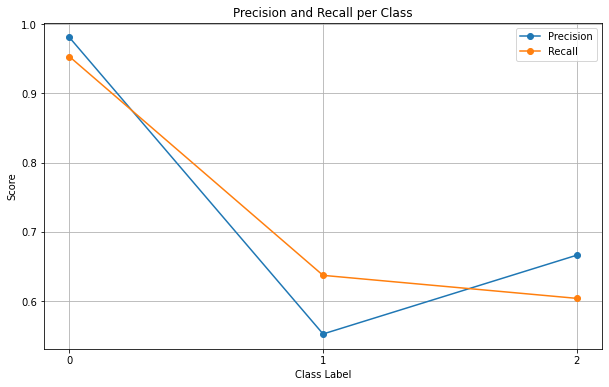

In [0]:
# Assuming 'predictions' contains the predictions made by your model

# Extracting true labels and predicted labels
true_labels_rf = predictions_rf.select("Diabetes_012").rdd.map(lambda row: row[0])
predicted_labels_rf = predictions_rf.select("prediction").rdd.map(lambda row: row[0])

# Combining true labels and predicted labels into a single RDD of (true_label, predicted_label) tuples
prediction_and_labels_rf = true_labels_rf.zip(predicted_labels_rf)

# Creating a MulticlassMetrics object
metrics = MulticlassMetrics(prediction_and_labels_rf)

# Get unique labels
unique_labels = sorted(set(true_labels_rf.collect()))

# Calculate precision and recall for each class
precision_per_class = []
recall_per_class = []
for label in unique_labels:
    try:
        precision = metrics.precision(label)
        recall = metrics.recall(label)
        precision_per_class.append(precision)
        recall_per_class.append(recall)
    except:
        precision_per_class.append(0.0)
        recall_per_class.append(0.0)

# Plot precision and recall
plt.figure(figsize=(10, 6))
plt.plot(unique_labels, precision_per_class, label='Precision', marker='o')
plt.plot(unique_labels, recall_per_class, label='Recall', marker='o')
plt.xlabel('Class Label')
plt.ylabel('Score')
plt.title('Precision and Recall per Class')
plt.xticks(unique_labels)
plt.legend()
plt.grid(True)
plt.show()

In [0]:
lr_classifier = LogisticRegression(featuresCol='features',
                        labelCol='Diabetes_012',
                        family="multinomial",
                        regParam=0.05,
                        elasticNetParam=0,
                        maxIter=50)

model = lr_classifier.fit(train)
predictions_lr = model.transform(test)

In [0]:
evaluator = MulticlassClassificationEvaluator()
evaluator.setLabelCol("Diabetes_012")
evaluator.setPredictionCol("prediction")
print("Accuracy: ", evaluator.evaluate(predictions_lr, {evaluator.metricName: "accuracy"}))

Accuracy:  0.5383669409530699


In [0]:
nb_classifier = NaiveBayes(smoothing=0.05, modelType="multinomial", featuresCol="features", labelCol="Diabetes_012", thresholds=[0.3, 0.3, 0.4])
model_nb = nb_classifier.fit(train)
predictions_nb = model_nb.transform(test)

In [0]:
evaluator = MulticlassClassificationEvaluator()
evaluator.setLabelCol("Diabetes_012")
evaluator.setPredictionCol("prediction")
print("Accuracy: ", evaluator.evaluate(predictions_nb, {evaluator.metricName: "accuracy"}))

Accuracy:  0.43165747355095396


In [0]:
# gbt_classifier = GBTClassifier(featuresCol="features", labelCol="Diabetes_012",maxDepth=10, maxIter=20)
# model = gbt_classifier.fit(train)
# predictions_gbt = model.transform(test)

In [0]:
# evaluator = MulticlassClassificationEvaluator()
# evaluator.setLabelCol("Diabetes_012")
# evaluator.setPredictionCol("prediction")
# print("Accuracy: ", evaluator.evaluate(predictions_gbt, {evaluator.metricName: "accuracy"}))

In [0]:
train, test

Out[50]: (DataFrame[Diabetes_012: double, HighBP: double, HighChol: double, CholCheck: double, BMI: double, Smoker: double, Stroke: double, HeartDiseaseorAttack: double, PhysActivity: double, Veggies: double, HvyAlcoholConsump: double, NoDocbcCost: double, GenHlth: double, MentHlth: double, PhysHlth: double, DiffWalk: double, Age: double, Education: double, Income: double, features: vector, scaled_features: vector],
 DataFrame[Diabetes_012: double, HighBP: double, HighChol: double, CholCheck: double, BMI: double, Smoker: double, Stroke: double, HeartDiseaseorAttack: double, PhysActivity: double, Veggies: double, HvyAlcoholConsump: double, NoDocbcCost: double, GenHlth: double, MentHlth: double, PhysHlth: double, DiffWalk: double, Age: double, Education: double, Income: double, features: vector, scaled_features: vector])

In [0]:
# layers = [4, 5, 4, 3]
# mlp_classifier = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=42, featuresCol="features", labelCol="Diabetes_012")
# model_mlp = mlp_classifier.fit(train)
# predictions_mlp = model_mlp.transform(test)

In [0]:
layers = [len(train.select('features').take(1)[0][0]), 5, 4, len(train.select('Diabetes_012').distinct().collect())]

# Create the Multilayer Perceptron Classifier
mlp = MultilayerPerceptronClassifier(labelCol="Diabetes_012",maxIter=100, layers=layers, blockSize=128, seed=1234)

# Train the model
mlp_model = mlp.fit(train)

# Make predictions on the test data
predictions_mlp = mlp_model.transform(test)

In [0]:
evaluator = MulticlassClassificationEvaluator()
evaluator.setLabelCol("Diabetes_012")
evaluator.setPredictionCol("prediction")
print("Accuracy: ", evaluator.evaluate(predictions_mlp, {evaluator.metricName: "accuracy"}))

Accuracy:  0.5288904964282485


In [0]:
# Assuming 'predictions' contains the predictions made by your model

# Extracting true labels and predicted labels
true_labels_mlp = predictions_mlp.select("Diabetes_012").rdd.map(lambda row: row[0])
predicted_labels_mlp = predictions_mlp.select("prediction").rdd.map(lambda row: row[0])

# Combining true labels and predicted labels into a single RDD of (true_label, predicted_label) tuples
prediction_and_labels_mlp = true_labels_mlp.zip(predicted_labels_mlp)

# Creating a MulticlassMetrics object
metrics = MulticlassMetrics(prediction_and_labels_mlp)

# Get unique labels
unique_labels = set(true_labels_mlp.collect())

# Calculate precision and recall for each class
precision_recall_per_class = {}
for label in unique_labels:
    try:
        precision = metrics.precision(label)
        recall = metrics.recall(label)
        precision_recall_per_class[label] = (precision, recall)
    except:
        precision_recall_per_class[label] = (0.0, 0.0)  # Handle the case where precision and recall are not available

# Print precision and recall for each class
for label, (precision, recall) in precision_recall_per_class.items():
    print(f"Class {label}: Precision = {precision:.4f}, Recall = {recall:.4f}")
print(metrics.confusionMatrix())

print(true_labels_mlp.distinct().collect())
print(prediction_and_labels_mlp.distinct().collect())

print("Precision: ", evaluator.evaluate(predictions_mlp, {evaluator.metricName: "weightedPrecision"}))
print("Recall ", evaluator.evaluate(predictions_mlp, {evaluator.metricName: "weightedRecall"}))

Class 0.0: Precision = 0.5812, Recall = 0.6925
Class 1.0: Precision = 0.2440, Recall = 0.4247
Class 2.0: Precision = 0.7601, Recall = 0.4797
DenseMatrix([[21483.,  6796.,  2745.],
             [ 6027.,  8959.,  6108.],
             [ 9455., 20969., 28048.]])
[0.0, 1.0, 2.0]
[(2.0, 0.0), (0.0, 0.0), (1.0, 0.0), (1.0, 1.0), (1.0, 2.0), (0.0, 2.0), (2.0, 2.0), (0.0, 1.0), (2.0, 1.0)]
Precision:  0.5325529998872367
Recall  0.5288904964282485


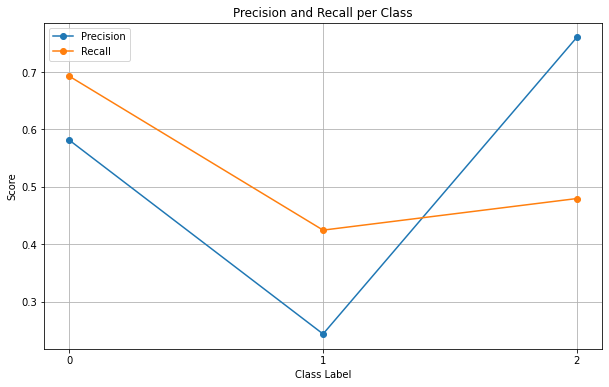

In [0]:
# Assuming 'predictions' contains the predictions made by your model

# Extracting true labels and predicted labels
true_labels_mlp = predictions_mlp.select("Diabetes_012").rdd.map(lambda row: row[0])
predicted_labels_mlp = predictions_mlp.select("prediction").rdd.map(lambda row: row[0])

# Combining true labels and predicted labels into a single RDD of (true_label, predicted_label) tuples
prediction_and_labels_mlp = true_labels_mlp.zip(predicted_labels_mlp)

# Creating a MulticlassMetrics object
metrics = MulticlassMetrics(prediction_and_labels_mlp)

# Get unique labels
unique_labels = sorted(set(true_labels_mlp.collect()))

# Calculate precision and recall for each class
precision_per_class = []
recall_per_class = []
for label in unique_labels:
    try:
        precision = metrics.precision(label)
        recall = metrics.recall(label)
        precision_per_class.append(precision)
        recall_per_class.append(recall)
    except:
        precision_per_class.append(0.0)
        recall_per_class.append(0.0)

# Plot precision and recall
plt.figure(figsize=(10, 6))
plt.plot(unique_labels, precision_per_class, label='Precision', marker='o')
plt.plot(unique_labels, recall_per_class, label='Recall', marker='o')
plt.xlabel('Class Label')
plt.ylabel('Score')
plt.title('Precision and Recall per Class')
plt.xticks(unique_labels)
plt.legend()
plt.grid(True)
plt.show()

In [0]:
# evaluator = MulticlassClassificationEvaluator(metricName="accuracy", labelCol="Diabetes_012", predictionCol="prediction")
# evaluator.setLabelCol("Diabetes_012")
# evaluator.setPredictionCol("prediction")
# mlpc_accuracy = evaluator.evaluate(predictions)
# print("Accuracy: ", mlpc_accuracy)

In [0]:
# Configure and train the XGBoost model
xgb_classifier = XGBoostClassifier(featuresCol="features", labelCol="Diabetes_012", eta=0.1, maxDepth=10, numClass=3, numRound=100, numWorkers=4, seed=42, objective="multi:softmax", subsample=0.8, colsampleBytree=0.6)

model = xgb_classifier.fit(train)

# Make predictions
predictions_xg = model.transform(test)

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-2593147573175771>:2
      1 # Configure and train the XGBoost model
----> 2 xgb_classifier = XGBoostClassifier(featuresCol="features", labelCol="Diabetes_012", eta=0.1, maxDepth=10, numClass=3, numRound=100, numWorkers=4, seed=42, objective="multi:softmax", subsample=0.8, colsampleBytree=0.6)
      4 model = xgb_classifier.fit(train)
      6 # Make predictions

File /databricks/spark/python/pyspark/__init__.py:135, in keyword_only.<locals>.wrapper(self, *args, **kwargs)
    133     raise TypeError("Method %s forces keyword arguments." % func.__name__)
    134 self._input_kwargs = kwargs
--> 135 return func(self, **kwargs)

File /local_disk0/.ephemeral_nfs/envs/pythonEnv-e20836ac-fe25-402e-b1e9-00461cc71512/lib/python3.9/site-packages/sparkxgb/xgboost.py:81, in XGBoostClassifier.__init__(self, alpha, baseMarginCol, baseScor

In [0]:
evaluator = MulticlassClassificationEvaluator()
evaluator.setLabelCol("Diabetes_012")
evaluator.setPredictionCol("prediction")
print("Accuracy: ", evaluator.evaluate(predictions_xg, {evaluator.metricName: "accuracy"}))

In [0]:
# Assuming 'predictions' contains the predictions made by your model

# Extracting true labels and predicted labels
true_labels_dt = predictions_dt.select("Diabetes_012").rdd.map(lambda row: row[0])
predicted_labels_dt = predictions_dt.select("prediction").rdd.map(lambda row: row[0])

# Combining true labels and predicted labels into a single RDD of (true_label, predicted_label) tuples
prediction_and_labels_dt = true_labels_dt.zip(predicted_labels_dt)

# Creating a MulticlassMetrics object
metrics = MulticlassMetrics(prediction_and_labels_dt)

# Get unique labels
unique_labels = set(true_labels_dt.collect())

# Calculate precision and recall for each class
precision_recall_per_class = {}
for label in unique_labels:
    try:
        precision = metrics.precision(label)
        recall = metrics.recall(label)
        precision_recall_per_class[label] = (precision, recall)
    except:
        precision_recall_per_class[label] = (0.0, 0.0)  # Handle the case where precision and recall are not available

# Print precision and recall for each class
for label, (precision, recall) in precision_recall_per_class.items():
    print(f"Class {label}: Precision = {precision:.4f}, Recall = {recall:.4f}")
print(metrics.confusionMatrix())

print(true_labels_dt.distinct().collect())
print(prediction_and_labels_dt.distinct().collect())

print("Precision: ", evaluator.evaluate(predictions_dt, {evaluator.metricName: "weightedPrecision"}))
print("Recall ", evaluator.evaluate(predictions_dt, {evaluator.metricName: "weightedRecall"}))

In [0]:
# Assuming 'predictions' contains the predictions made by your model

# Extracting true labels and predicted labels
true_labels_dt = predictions_dt.select("Diabetes_012").rdd.map(lambda row: row[0])
predicted_labels_dt = predictions_dt.select("prediction").rdd.map(lambda row: row[0])

# Combining true labels and predicted labels into a single RDD of (true_label, predicted_label) tuples
prediction_and_labels_dt = true_labels_dt.zip(predicted_labels_dt)

# Creating a MulticlassMetrics object
metrics = MulticlassMetrics(prediction_and_labels_dt)

# Get unique labels
unique_labels = sorted(set(true_labels_dt.collect()))

# Calculate precision and recall for each class
precision_per_class = []
recall_per_class = []
for label in unique_labels:
    try:
        precision = metrics.precision(label)
        recall = metrics.recall(label)
        precision_per_class.append(precision)
        recall_per_class.append(recall)
    except:
        precision_per_class.append(0.0)
        recall_per_class.append(0.0)

# Plot precision and recall
plt.figure(figsize=(10, 6))
plt.plot(unique_labels, precision_per_class, label='Precision', marker='o')
plt.plot(unique_labels, recall_per_class, label='Recall', marker='o')
plt.xlabel('Class Label')
plt.ylabel('Score')
plt.title('Precision and Recall per Class')
plt.xticks(unique_labels)
plt.legend()
plt.grid(True)
plt.show()

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Implementing Neural Network using PyTorch

In [0]:
x = new_df.loc[:, new_df.columns!="Diabetes_012"]
y = new_df.loc[:, new_df.columns == "Diabetes_012"]
x,y

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [0]:
sc = StandardScaler()
sc.fit(x_train)

In [0]:
# Performing scaling

x_train_sc = sc.transform(x_train)
x_test_sc = sc.transform(x_test)
y_train_sc = sc.fit_transform(y_train)

x_train_sc, x_test_sc

In [0]:
x_train.shape

In [0]:
xtrain_ten = torch.tensor(x_train_sc, dtype=torch.float32)
ytrain_ten = torch.tensor(y_train_sc, dtype=torch.long)  # Labels for multiclass classification

xtrain_ten, ytrain_ten.shape

In [0]:
# Define the neural network architecture
class DiabetesClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(DiabetesClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
input_size = x_train.shape[1]  # Number of input features
hidden_size1 = 64
hidden_size2 = 32
num_classes = 3  # Number of diabetes classes (e.g., no diabetes, type 1, type 2)
learning_rate = 0.001
batch_size = 64
num_epochs = 10

# Create a TensorDataset and DataLoader for training
train_dataset = TensorDataset(xtrain_ten, ytrain_ten)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create an instance of the DiabetesClassifier
model = DiabetesClassifier(input_size, hidden_size1, hidden_size2, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_X, batch_y in train_dataloader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device).squeeze()  # Ensure batch_y is a 1D tensor
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(batch_X)  # Forward pass
        loss = criterion(outputs, batch_y)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        total_loss += loss.item()
    
    # Print average loss per epoch
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader)}")

In [0]:
x_test_tensor = torch.tensor(x_test_sc, dtype=torch.float32).to(device)
y_test_array = y_test.values  # This converts the DataFrame to a NumPy array

# Convert NumPy array to PyTorch tensor with the correct dtype
y_test_tensor = torch.tensor(y_test_array, dtype=torch.long).to(device)

In [0]:
# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    _, predicted = torch.max(outputs, 1)  # Get predicted class indices

    # Calculate accuracy
    correct = (predicted == y_test_tensor).sum().item()
    accuracy = correct / len(y_test_tensor)
    print(f"Test Accuracy: {accuracy}")